# SHAHID ALI
## FA24-RAI-015
## Assignment 4

# Twitter Sentiment Analysis
Sentiment analysis is the automatic process of classifying text data according to their polarity, such as positive, negative and neutral. Companies leverage sentiment analysis of tweets to get a sense of how customers are talking about their products and services, get insights to drive business decisions, and identify product issues and potential PR crises early on.


In [2]:
# Install all necessary libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and text handling
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Warnings
import warnings
warnings.filterwarnings('ignore')

!pip install --quiet tensorflow_text

import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import stopwords

#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt_tab')


#stopwords.words('english')
exclude = string.punctuation
!pip install tensorflow_hub tensorflow_text


# About the Dataset
Each row contains the text of a tweet and a sentiment label. In the training set you are provided with a word or phrase drawn from the tweet (selected_text) that encapsulates the provided sentiment.
**The dataset has 27.5k tweets labelled according to their sentiment.**
Each row contains the text of a tweet and a sentiment label. In the training set you are provided with a word or phrase drawn from the tweet (selected_text) that encapsulates the provided sentiment.

### Columns
* `textID` - unique ID for each piece of text
* `text` - the text of the tweet
* `sentiment` - the general sentiment of the tweet
* `selected_text` - [train only] the text that supports the tweet's sentiment

In [3]:
# Load in the dataset
df= pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Exploratory Data Analysis

In [4]:
# Check the shape
print(df.shape)

(27481, 4)


In [5]:
# Check for missing values and drop them
print(df.isnull().sum())


textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [6]:
# drop missing values
df = df.dropna()
print(df.isnull().sum())

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


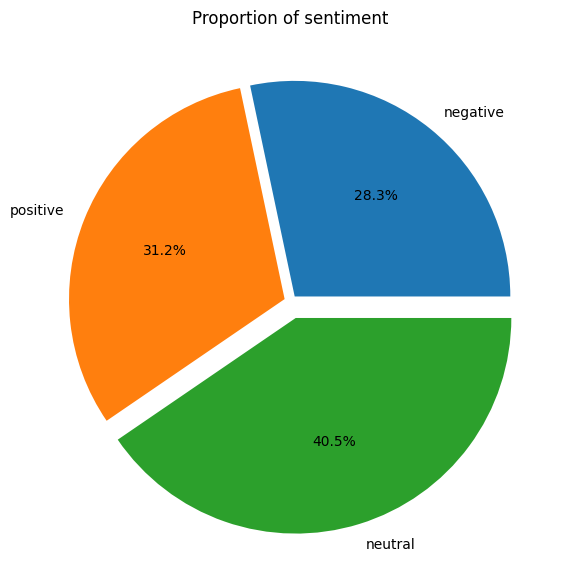

In [7]:
# check the proportion of each sentiment
x = df.sentiment.value_counts().sort_values()

plt.figure(figsize=(7, 7))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

# Word Cloud
A word cloud is a visual representation of text data which is often used to depict keyword metadata on websites, or to visualize free form text.  

 **Word Clouds** for **Positive, Negative and Neutral** tweets from  dataset and see which words occur the most.

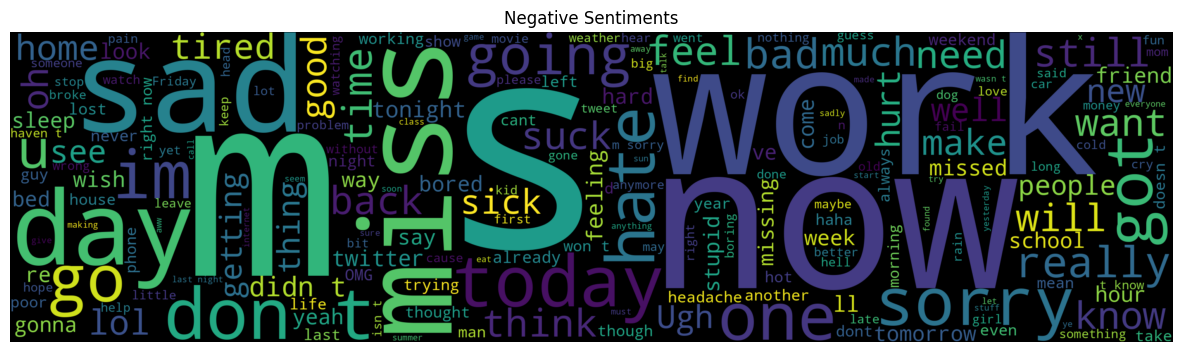

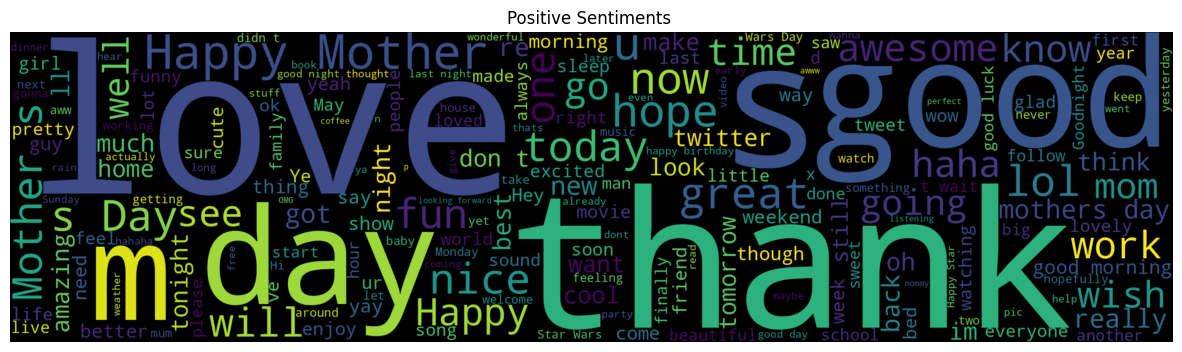

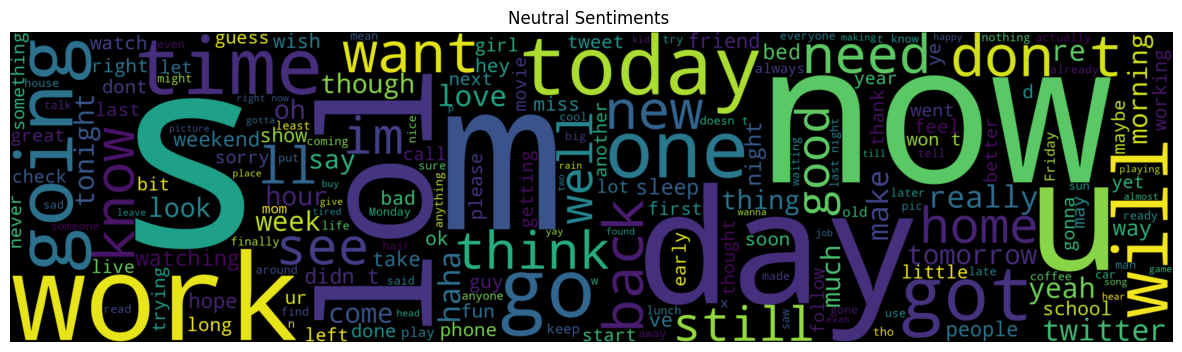

In [8]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiments')
generate_wordcloud(positive_df, 'Positive Sentiments ')
generate_wordcloud(neutral_df, 'Neutral Sentiments ')

# Pre-processing


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# **Text Cleaning & Preprocessing**

In [11]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

exclude = "!.,?"
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))


In [12]:
df['text'] = df['text'].str.lower()

df['text'] = df['text'].apply(remove_html_tags)

df['text'] = df['text'].apply(remove_url)

df['text'] = df['text'].apply(remove_punc)



df['selected_text'] = df['selected_text'].str.lower()

df['selected_text'] = df['selected_text'].apply(remove_html_tags)

df['selected_text'] = df['selected_text'].apply(remove_url)

df['selected_text'] = df['selected_text'].apply(remove_punc)



# **Feature Engineering**

**Target Column Encoding**

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd


X = df['selected_text']
Y = df['sentiment']
#print(X)
#print(Y)

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

#print(Y)

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)


**BERT Encoding**

In [14]:
# Load BERT preprocessing and encoding models from TensorFlow Hub
import tensorflow_hub as hub
import tensorflow_text as text


preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False)

# Define function with smaller batches
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        text_input = tf.constant(batch_texts)
        preprocessed_text = preprocessor(text_input)
        outputs = encoder(preprocessed_text)
        pooled_output = outputs['pooled_output']
        embeddings.append(pooled_output.numpy())
    return np.vstack(embeddings)

# Process training and test sets
train_embeddings = get_bert_embeddings(X_train, batch_size=32)
test_embeddings = get_bert_embeddings(X_test, batch_size=32)

print("Train embeddings shape:", train_embeddings.shape)
print("Test embeddings shape:", test_embeddings.shape)


Train embeddings shape: (21984, 768)
Test embeddings shape: (5496, 768)


**ML Models**

**Random Forest**

Accuracy  0.7867540029112081
Confusion Matrix
[[1103  383   86]
 [ 159 2004   73]
 [ 127  344 1217]]


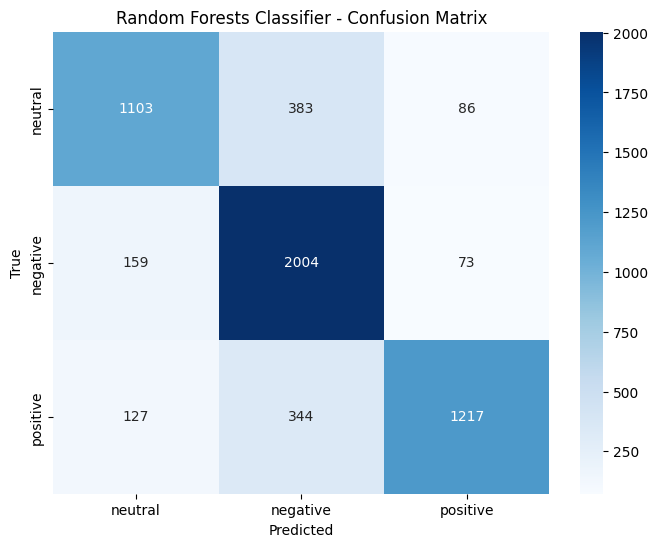

In [15]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(train_embeddings, y_train)

# Predict on the test set
y_pred = rf_model.predict(test_embeddings)

print ("Accuracy ",accuracy_score(y_test,y_pred))
print ("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

# Generate and plot the confusion matrix for Support Vector Classifier

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forests Classifier - Confusion Matrix')
plt.show()

**Logestic Regression**

Accuracy  0.8138646288209607
Confusion Matrix
[[1209  256  107]
 [ 194 1893  149]
 [ 102  215 1371]]


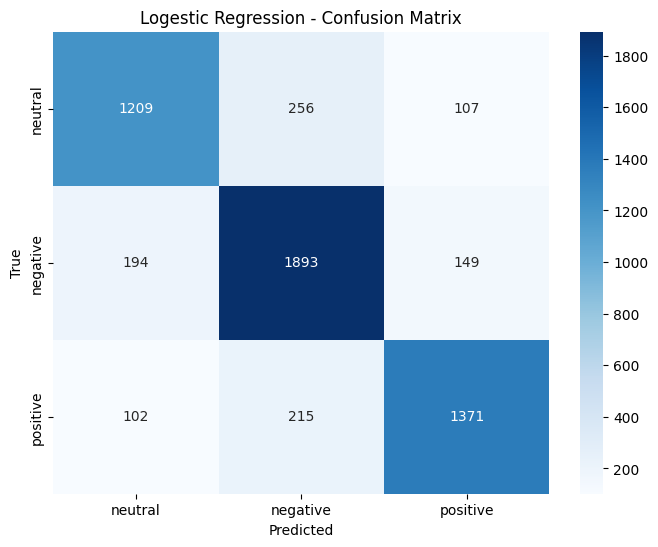

In [16]:
# Importing & calling Machine learning models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()


lr_model.fit(train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(test_embeddings)

print ("Accuracy ",accuracy_score(y_test,y_pred))
print ("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

# Generate and plot the confusion matrix for Support Vector Classifier

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logestic Regression - Confusion Matrix')
plt.show()




**Gradient Boosting**

Accuracy  0.7947598253275109
Confusion Matrix
[[1134  318  120]
 [ 175 1925  136]
 [ 118  261 1309]]


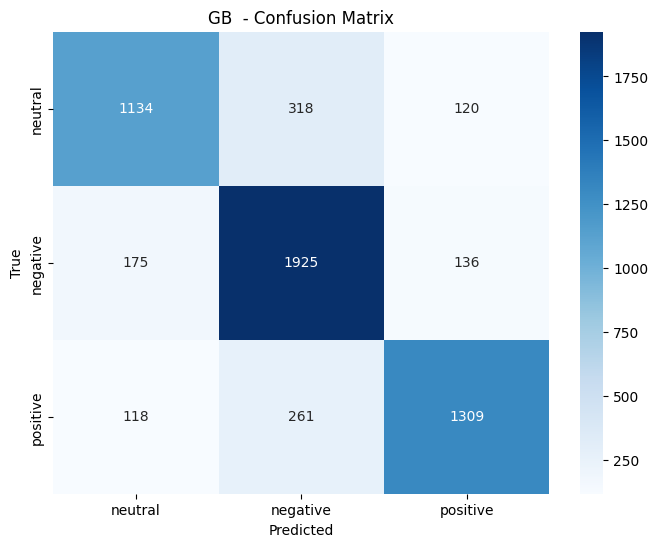

In [17]:

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state=42)

GB.fit(train_embeddings, y_train)

# Predict on the test set
y_pred = GB.predict(test_embeddings)

print ("Accuracy ",accuracy_score(y_test,y_pred))
print ("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

# Generate and plot the confusion matrix for Support Vector Classifier

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GB  - Confusion Matrix')
plt.show()

**Support Vector Machine**

Accuracy  0.8013100436681223
Confusion Matrix
[[1155  316  101]
 [ 170 1959  107]
 [ 144  254 1290]]


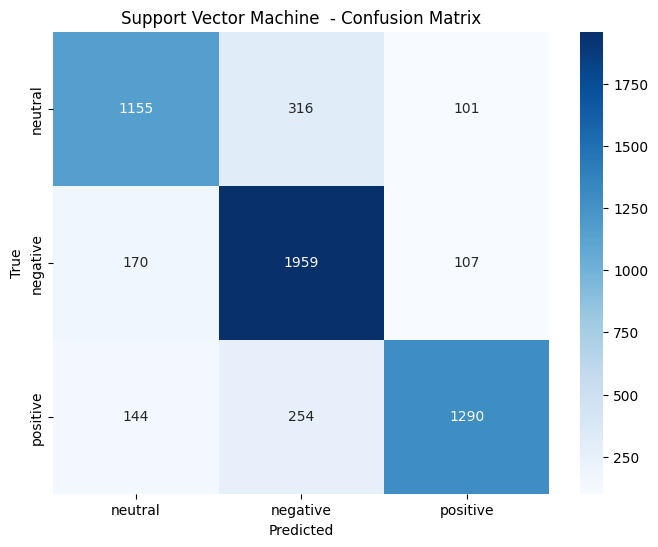

In [18]:

# Support Vector Machine
from sklearn.svm import SVC
svc = SVC()

svc.fit(train_embeddings, y_train)

# Predict on the test set
y_pred = svc.predict(test_embeddings)

print ("Accuracy ",accuracy_score(y_test,y_pred))
print ("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

# Generate and plot the confusion matrix for Support Vector Classifier

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Support Vector Machine  - Confusion Matrix')
plt.show()



**Model Comparison**

In [ ]:
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
# Importing & calling Machine learning models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

# Support Vector Machine
from sklearn.svm import SVC
svc = SVC()

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state=42)


models = [lr_model, svc, rfc, GB]
accuracy_scores = []

# training models
for model in models:

    model.fit(train_embeddings, y_train)
    y_pred = model.predict(test_embeddings)

    acc = accuracy_score(y_test,y_pred)
    accuracy_scores.append(acc)

    print(model)
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print()


models = ['Logistic Regression', 'Support Vector', 'Random Classifier', 'Gradient Boosting']
plt.plot(models, accuracy_scores, label='Accuracy Score', marker='o', linestyle='-', color='b', linewidth=2)
plt.fill_between(models, accuracy_scores, color='lightblue', alpha=1)
plt.xlabel('Model')
plt.ylabel('Accuracy Value')
plt.title('Model Comparison')

LogisticRegression()
Accuracy Score: 0.8138646288209607

SVC()
Accuracy Score: 0.8013100436681223

RandomForestClassifier()
Accuracy Score: 0.7863901018922853



**Classification Report**

In [ ]:
print("Classification Report for Support Vector Classifier:\n", classification_report(y_test, y_pred, target_names=df['sentiment'].unique()))

**Test Your own Tweets**

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(["positive", "negative","neutral"])

text = ["I hate twitter"]

# Generate embeddings for the new text input
text_embeddings = get_bert_embeddings(text)

# Predict sentiment using the trained model
predicted_label = rf_model.predict(text_embeddings)

# Map the predicted label back to its original category
predicted_category = label_encoder.inverse_transform(predicted_label)

print(f"Text: {text[0]}")
print(f"Predicted Sentiment: {predicted_category[0]}")


Text: I hate twitter
Predicted Sentiment: negative


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(["positive", "neutral", "negative"])

# Single text input for prediction
text = ["Weather is  awesome today"]

# Generate embeddings for the new text input
text_embeddings = get_bert_embeddings(text)

# Predict sentiment using the trained model
predicted_label = rf_model.predict(text_embeddings)

# Map the predicted label back to its original category
predicted_category = label_encoder.inverse_transform(predicted_label)

print(f"Text: {text[0]}")
print(f"Predicted Sentiment: {predicted_category[0]}")
